## 필요한 데이터 불러오기 및 접근

## 필요한 라이브러리 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/nlp_liflow/

/content/drive/My Drive/nlp_liflow


In [3]:
!ls

자연어처리_1.ipynb		  sen_preprocessig.csv
자연어처리_2.ipynb		  스포츠_sen_prerprocessing.csv
all_df_with_tokens.csv		  sentence_Summarizer.ipynb
all_sen.csv			  textrank
cc.ko.300.bin.gz		  textrank_git
first_embedding_clustering.model  자연어처리_tomotopy_HDPModel.ipynb
ko.bin				  자연어처리_tomotopy.ipynb
list_to_csv.csv			  자연어처리_tomotopy_modeling.ipynb
nlp_tokenizer.ipynb		  word2vec_model
스포츠_sen.csv


In [4]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-11-09 13:03:09--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-11-09 13:03:09--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc963e8165df7701d3cdf84b31a9.dl.dropboxusercontent.com/cd/0/get/BwapDGfvBakpchGqbqQukg5Xn5-kvNWkxyTui0IBMdl_h-nOB0l7wNoUVa2nHPehMsGSCtGHsEiuUiJ6jkriBeh8abQuF6Z0f-n2vtjt7dXmoVT10vAAmaXwTe-jjbM0vvF4v1kC72T2TPfjVz_ToQ-gw6Ol-ZwsSuDKGHW2Ir2u7QX46RL68UbfbWJSEU98U-A/file?dl=1# [following]
--2022-11-09 13:03:10--  https://uc963e8165df7701d3cdf84b31a9.dl.dropboxusercontent.com/cd/0/get/BwapDGfvBakp

In [5]:
!pip install kss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.4 MB 2.7 MB/s 
     |████████████████████████████████| 131 kB 47.1 MB/s 
  Created wheel for kss: filename=kss-3.6.4-py3-none-any.whl size=42448614 sha256=517de89964e2a2a97a0ebbace6fb6f9e61d7d261db16b8647e33ea2d069295bc
  Stored in directory: /root/.cache/pip/wheels/32/53/7c/76bdf098c2a6c5cd4c4c29648da30ad4793d604314b2aeb26f
Successfully built kss


In [93]:
import textrank_git
from textrank_git import rank
from textrank_git import sentence
from textrank_git import summarizer
from textrank_git import utils
from textrank_git import word
import re
import kss
import pandas as pd
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import gensim
import logging
import os
from collections import namedtuple, defaultdict
from collections.abc import Iterable
from timeit import default_timer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from numpy import zeros, float32 as REAL, vstack, integer, dtype
import numpy as np
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.utils import deprecated
from gensim.models import Word2Vec # noqa: F401
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [131]:
mecab = Mecab()
def mecab_tokenize(sent):
  w = []
  a = re.compile('[^ ㄱ-ㅣ가-힣]+')
  words = mecab.pos(sent, join=True)
  word = [a.sub(r'',w) for w in words if ('/NNG' in w or '/NNP' in w or '/VV' in w or '/VA' in w
)]
  
  for i in range(len(word)):
    if len(word[i])!=1:
      w.append(word[i])
  return w

'''
해당 함수는 추후에 사용될 키워드 추출, 키센텐스 추출에 필요한 토크나이저 함수입니다.
현재 /NNP, NNG, /XR , /VV, /VA 만을 추출하여 키워드/키센텐스를 추출하도록 짜여져 있습니다.
'''

'\n해당 함수는 추후에 사용될 키워드 추출, 키센텐스 추출에 필요한 토크나이저 함수입니다.\n현재 /NNP, NNG, /XR , /VV, /VA 만을 추출하여 키워드/키센텐스를 추출하도록 짜여져 있습니다.\n'

## 데이터 정리

###### 여기서 문장별로 나뉘어진 대화 셋을 한 대화로 합치고, 필요한 대화의 데이터의 카테고리를 재정의합니다.

In [8]:
files = pd.read_csv('all_df_with_tokens.csv', encoding ='utf-8', index_col = 0)
main_df = pd.DataFrame(columns = ['sentence', 'convrsThema'])
a = []
for i in range(len(files['convrsThema'])-1):
  if files['convrsThema'][i]==files['convrsThema'][i+1]:
    a.append(files['sentence'][i])

  else:
    a_str = " ".join(a)
    df = pd.DataFrame({'sentence' : a_str, 'convrsThema' : files['convrsThema'][i]}, index = [0])
    main_df = main_df.append(df, ignore_index = True)
    a = []
    
i = main_df[main_df['sentence']==""].index
main_df = main_df.drop(i)

main_df['convrsThema'] = main_df['convrsThema'].str.replace('코로나/생활', '투병')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('메르스', '투병')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('축구선수', '축구')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 문학 ', '책')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('독서', '책')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('문학', '책')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('집값', '부동산')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('분양', '부동산')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('직업', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('일', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('좋은글,사자성어,좋은글귀,등등 읽으면 도움이되는 글들..', '좋은글')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('국제관계', '정치')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('제테크', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('시사/재테크', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 경제/재테크 ', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 경제/재태크 ', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 자연/휴양지 ', '자연/여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자동차보험', '교통사고/보험')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('교통사고', '교통사고/보험')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('운전', '자동차')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 자동차 ', '자동차')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀취업', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀직장', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀입대', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀교육', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀결혼', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀 취업', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀 교육', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀 결혼', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('일상생활', '일상')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('일상 이야기', '일상')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('일상대화', '일상')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('#일상', '일상')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('이사', '이사/이민')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('이민', '이사/이민')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('먹거리', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('먹거리/건강', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 먹거리 ', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('육아', '육아')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('양육/교육', '육아')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('교육', '교육')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('운동', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 스포츠/레저 ', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('영화관', '영화관')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 영화 ', '영화')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('연예인', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 방송/연예 ', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 연애/결혼 ', '연애')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여행계획', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여가생활', '여가')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('시댁살이', '시집살이')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('시댁', '시집살이')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('말씀나누기', '대화')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 만화 ', '만화')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('결혼생활', '결혼')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('남편', '결혼')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강/다이어트', '다이어트')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 건강/다이어트 ', '다이어트')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('노후준비', '노후')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('노후대책', '노후')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('넷플릭스', '방송')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('TV', '방송')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('드라마', '방송')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 군대 ', '군대')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강/교육', '건강')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('가족건강', '건강')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('가정', '가족')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('#인생', '인생')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('반려동물,강아지', '반려동물')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 국가/지역 ', '국가/지역')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 게임 ', '게임')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강식', '건강식품')

main_df['convrsThema'] = main_df['convrsThema'].str.replace('수영', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('볼링', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('축구', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('야구', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('배구', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('골프', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('직장상', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('#직장상', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('직장화', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('피시방', '게임')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('요리', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('밥', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강식품품', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강식품', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('식습관', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('음식점', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('음식/건강', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('영양제', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('제주도', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('휴양지', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('등산', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('캠핑', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여가', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('게읻트볼', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자전거', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('스쿠버다이빙', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('해외여행', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강검진', '건강')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('연애/결혼', '연애')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('육아', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('스포츠/레저', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('재태크', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('부동산', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('경제', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('아파트', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('재개발', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('돈', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('경제/재테크', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('방송', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('영화', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('영화관', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('방송/연예/연예', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('책', '교육')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('교통사고/보험/보험', '교통사고/보험')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자동차면허', '자동차')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('벌초', '제사')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('장례', '제사')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('학창시절', '친구')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('스포츠/레저', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여행/건강', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여행/자녀', '자녀')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future version.


In [9]:
main_df

sentence convrsThema
0      밥 한끼를 제대로 된 밥 한끼를 먹을 수 있다고 생각하면서 감사하게 감사하게 생각하...       방송/연예
1      그거 먹고 살아야 되는 거지 자식 물려줄 필요없고요 그걸로 모자라는 부분은 다른 곳...         재테크
2      결국 주차 요금을 올릴 수밖에 없어요 결국 최씨는 수리를 삼십일로 미뤄야 했습니다 ...         PBS
3      저 사람이 나한테 저렇게 행동을 하는구나 저 사람이 원하는 게 무엇인가를 내가 생각...        휴직장 
4      이 사람의 입장은 이럴 수 있구나 라고 배울 수 있는거지 그런건 정말 중요하고 꼭 ...         음식 
...                                                  ...         ...
13076  나는 궁금했던 사람이 별로 생각나지 않는데 예전에 도깨비 드라마 볼 때 한번 보고 ...       방송/연예
13078  나는 궁금했던 사람이 별로 생각나지 않는데 (SN:) 예전에 도깨비 드라마 볼 때 ...       방송/연예
13086      늘 사 먹게 되는데 그런 세태가 바뀌어야 할텐데 쉽지 않은 (SP:일이) 일이지요          음식
13087  세단 외에 우리가 차를 가지게 된 것이 (SP:놀) 놀러가려는 이유도 (NO:있었지...         자동차
13088  기술이 계속 발전하고 (SP:있으니) 있으니까 그런 식으로 새로운 기술을 접목시키게...         자동차

[10772 rows x 2 columns]

## 우선적으로 학습에 사용할 데이터 확보
###### 스포츠 데이터가 상당량 차지하고 있기 때문에 스포츠만 가지고 학습을 진행합니다.

In [10]:
main_df.value_counts(main_df['convrsThema'])

convrsThema
재테크       942
스포츠       917
방송/연예     731
자동차       715
여행        692
         ... 
직장 이야기      1
미래          1
반려동물        1
부산          1
직장반         1
Length: 84, dtype: int64

In [11]:
condition1 = (main_df['convrsThema'] == '스포츠')
thema = main_df.loc[condition1]
thema

sentence convrsThema
381    어제 탁구 시합할 때 빽 서브 연습을 안 하고 하니까  서브가 그게 잘 들어가던데 ...         스포츠
387    잘 안되더라 연습 하고 가야겠어 연습을 조금만 (SP:해가) 공이 허공으로 뜨고 그...         스포츠
393    어제 탁구 시합할 때 백 서브 연습을 안 하고 하니까  잘 안되더라 연습을 하고 가...         스포츠
400    (SP:이)제 탁구 시합을 (SP:택 팩)서브 연습을 (NO:안 하고 하니까 ) 어...         스포츠
406    (NO:)나도 유튜브를 본지 얼마 안됐는데  그래서 그만 둘까 하니까(SP: 사람들...         스포츠
...                                                  ...         ...
13012  근데 그렇게 멋있는 샷을 (NO:) 사라운드에서도 했어도 한번 무너지면 그래\r\n...         스포츠
13013  삼십분 매일 하는 것은 괜찮은데 (NO:너무 운동장만) 도는 것 말고도\r\n 요즘...         스포츠
13015  동네를 한바퀴 돌아도 되고 아빠트 단지를 한바퀴 돌아도 되고\r\n 그전에는 애들을...         스포츠
13017  스트레칭 시간이 이렇게 정해져 있기 때문에 (NO:) 십년 동안 하다보니까\r\n ...         스포츠
13065  나도 배드민턴 해봤지만 (NO:) 배드민턴 채 하나에 (SP:기) 기본적으로 최소 ...         스포츠

[917 rows x 2 columns]

In [12]:
thema.to_csv("스포츠_sen.csv") 
## 추후에 모델에 사용할 train 10개 문장을 고르기 위해 미리 csv 파일로 스포츠 대화 셋을 저장해 두었습니다.

## 데이터 전처리 
###### 데이터의 특수문자나 영어를 제외하고, kss를 사용해 문장을 재분류하는 과정을 거칩니다.

###### 이때 sents_all은 전처리 완료한 "스포츠"카테고리 대화 전체 데이터 셋을 말하며

###### sents는 학습에 sents_all 데이터 셋 중에서도 우선적으로 사용할 데이터 셋입니다.

In [13]:
#condition1 = (main_df['convrsThema'] == '스포츠')
#thema = main_df.loc[condition1]
import re
import kss
sents_all = []
k = []
for i in thema['sentence']:

  remain_pattern = re.compile(r'\([^)]*\)')
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')

  ws_replace = re.sub(r'\xa0', r'', i)
  text_rm = remain_pattern.sub(r'', ws_replace)
  text = hangul.sub(r'', text_rm)
  k = kss.split_sentences(text)
  
  sents_all.append(k)
  k = []
sents_all ## sents_all은 "스포츠" 카테고리를 갖는 전체 대화 셋을 말합니다.

[['어제 탁구 시합할 때 빽 서브 연습을 안 하고 하니까 서브가 그게 잘 들어가던데 잘 안되더라 연습을 하고 가야겠어 연습을 조금만 하니까 공이 허공으로 뜨고 그러니까 상대방이 바로 때리니까 안 좋기는 안 좋더라고 가끔가다 한 번씩 때려주면 좋을 텐데 진짜 시합 할 때 빽 서브도 좋지만 화서브도 넣고 커트도 잘 되는데 커트가 잘 안될 때도 있잖 근데 빽 서브만 넣으면 안 되겠어 화서브 넣어도 상대방이 잘 알아서 때리니까 좀 그렇더라고 처음에 서브 넣으면 막 때리고 그러니까 한 번 때려 갖고 들어가면 기분이 안좋고 그날 진짜 플레이가 안 되더라고',
  '그런데 커트로 수비도 잘 하고 스매싱도 잘 하는데 단식보다 이제 복식 하면 뒤에서 스매싱으로 때려주면 되고 앞에서 수비 잘 하면 게임이 유리한 것 같은데 때리고 그러면 좀 실수가 많은 거 같지 않아 엊그제는 유튜브를 봤는데 유남규 선수 있잖아 유남규 선수가 설명을 잘해 주더라고 나도 유튜브를 본지 얼마 안됐는데 그게 도움이 많이 되는 거 같더라고 나도 가끔씩 보면 충분히 나도 할 수 있을 것 같은데 막상 게임 할 때는 잘 안 되더라고 맞아 그래서 연습을 많이 해야 할 것 같아 근데 나는 너무 안되서 레슨을 조금 받는데 하루에 십분 씩해서 일주일에 두 번 받거든',
  '확실히 받아보니까 조금 낫긴 하더라고',
  '근데 육만 원이야',
  '그게 확 티는 안나도 레슨 받은게 도움이 되고 오래 친 사람들도 계속 연습하면서 일 년에 한두 번씩 레슨을 받는다니까 그러니까 그렇게 잘 치는 거 같애',
  '잘 하는 분인데 내가 물어봤어 요즘에 많이 좋아졌더라고',
  '십분 정도 레슨을 받는데 잘하는 사람이랑 하니까 그 사람이 실수가 많이 줄었더라고',
  '그런데 또 잘 치는 사람들을 구경을 하는 것도 큰 도움이 되는 거 같애',
  '그지 나도 비슷하게라도 흉내를 낼라고 하면서 그것도 맞는 거 같어 내가상대방이 치는걸 보는데 내가 좀 해 볼라고 하면 잘 안 되고 좀 그렇더라 다른 사람이 치는건 잘 보이는데 내가 

## 원본 대화(스포츠)의 키워드 추출하기
key_textrank는 원문 키워드를 말하며

해당 과정은 textrank를 사용해 추출되었습니다.

이 작업은 추후에 doc2vec을 사용해 군집분석을 진행할 때 사용될 단어 리스트를 추리는 작업입니다.

In [14]:
for j in range(len(sents_all)):
  if len(sents_all[j])<=2:
    print(sents_all[j])

['여러가지 이 혈액순환이라든가 건강이 좋아 하다 보니까 나는 근력도 많이 좋아졌어 지금도 열심히 하는 중인 걸 모르지 다치는 경우도 많고 항상 내내가 도와줬어 해 보고 다 해 봤지만 요가가 더 좋은거 같아 워낙 좋아하다 보니까 일요일마다 갔어 한 번 보면 굉장히 느낌이 좋아 요가를하고 호흡법이 많이 좋아졌다고 생각해']
['나는 런닝머신을 한 삼십 분 정도 하는데 좋았어']
['서 무릎이 안 좋으신 분들 같은 경우는 자전거 타 나 좋다고 생각하거든요', '그러한 방식이']
['저는 이제 쉴 때에는 주로 운동을 해요']
['이제 제가 헬스하기 전에는 허리가 많이 안 좋아 허리 근력이 생기다 보니까 운동하는 게 너무 좋아']
['다들 바쁘겠지 바쁘겠지만 그래도 탁구가 좋아서 오는 사람들이 잖아 친구는 내가 이러게 같이 난타를 쳐 봤어', '진짜 이거는 진짜 반복해서 횟수가 문제인 것 같애 시간을 아무리 친다 해도 느는 게 속도가 반복돼 공 그렇게 쪼그만 게 사람들 갖고도 갖고 노는 거 보면 신기하다니까 나이 많이 먹어 갖고 남자들은 팔십도 넘더 라구']
['그런데 또 잘 치는 사람들을 구경을 하는 것도 큰 도움이 되는 거 같애', '그치 구 대회도 나가고 이제 잘 하다 보면 이제 시 대회도 나갈 수도 있잖아']
['스매싱 싱도 잘 되고 하는데 이제 저기 단식보다 복식을 하면 뒤에서 때려주고 근데 육만원이여 근데 받아보니까 조금 낫긴 낫더라고', '인제 나가기는 해도 어떨 때 속상할때가 많아 왜냐면 내가 너무 안 되니까']
['그게 그래서 그 회장님이 그 얘기 했자나']
['그게 잘 들어가던데 빽 서브 넣는게 카드도 잘 되고 하는데 카드가 조금 안될 때도 있잖아 스매싱도 잘 하고 그런데 카트로 수비도 잘해야지만 공 그런데 또 잘 치는 사람들을 구경을 하는 것도 큰 도움이 되는 것 같애', '그지 그게 나도 그렇게 할라고 비슷하게하더라도 흉내를 낼라고 하면서']
['이제 뭐 스쿼트나 런지 같은 거 요런 거 다 해서 다리가 좋아']
['좀 아플 때도 있고 약간 그럴 

In [15]:
import textrank_git
from textrank_git import rank
from textrank_git import sentence
from textrank_git import summarizer
from textrank_git import utils
from textrank_git import word

keyword_extractor = summarizer.KeywordSummarizer(
    tokenize = mecab_tokenize,
    window = -1,  
    min_count = 1,                                    
    verbose=False
)

key_textrank = []
key = []
a = []
k = []
for j in range(len(sents_all)):
  if len(sents_all[j])<=3:  # 대화가 2개 이하인 경우는 제외하고 대화 키워드 수집
    pass
  else:
    keywords = keyword_extractor.summarize(sents_all[j])
    for i in keywords:
      a.append(i[0])
    k.append(''.join(sents_all[j]))
    key_textrank.append(k)
    key.append(a)
    a = []
    k = []

key_textrank

[['어제 탁구 시합할 때 빽 서브 연습을 안 하고 하니까 서브가 그게 잘 들어가던데 잘 안되더라 연습을 하고 가야겠어 연습을 조금만 하니까 공이 허공으로 뜨고 그러니까 상대방이 바로 때리니까 안 좋기는 안 좋더라고 가끔가다 한 번씩 때려주면 좋을 텐데 진짜 시합 할 때 빽 서브도 좋지만 화서브도 넣고 커트도 잘 되는데 커트가 잘 안될 때도 있잖 근데 빽 서브만 넣으면 안 되겠어 화서브 넣어도 상대방이 잘 알아서 때리니까 좀 그렇더라고 처음에 서브 넣으면 막 때리고 그러니까 한 번 때려 갖고 들어가면 기분이 안좋고 그날 진짜 플레이가 안 되더라고그런데 커트로 수비도 잘 하고 스매싱도 잘 하는데 단식보다 이제 복식 하면 뒤에서 스매싱으로 때려주면 되고 앞에서 수비 잘 하면 게임이 유리한 것 같은데 때리고 그러면 좀 실수가 많은 거 같지 않아 엊그제는 유튜브를 봤는데 유남규 선수 있잖아 유남규 선수가 설명을 잘해 주더라고 나도 유튜브를 본지 얼마 안됐는데 그게 도움이 많이 되는 거 같더라고 나도 가끔씩 보면 충분히 나도 할 수 있을 것 같은데 막상 게임 할 때는 잘 안 되더라고 맞아 그래서 연습을 많이 해야 할 것 같아 근데 나는 너무 안되서 레슨을 조금 받는데 하루에 십분 씩해서 일주일에 두 번 받거든확실히 받아보니까 조금 낫긴 하더라고근데 육만 원이야그게 확 티는 안나도 레슨 받은게 도움이 되고 오래 친 사람들도 계속 연습하면서 일 년에 한두 번씩 레슨을 받는다니까 그러니까 그렇게 잘 치는 거 같애잘 하는 분인데 내가 물어봤어 요즘에 많이 좋아졌더라고십분 정도 레슨을 받는데 잘하는 사람이랑 하니까 그 사람이 실수가 많이 줄었더라고그런데 또 잘 치는 사람들을 구경을 하는 것도 큰 도움이 되는 거 같애그지 나도 비슷하게라도 흉내를 낼라고 하면서 그것도 맞는 거 같어 내가상대방이 치는걸 보는데 내가 좀 해 볼라고 하면 잘 안 되고 좀 그렇더라 다른 사람이 치는건 잘 보이는데 내가 칠 땐 잘 안되니까 어려워 생활 체육이지만 되게 탁구가 어려운거 같아 내가 배드민턴을 

In [16]:
"""
sen_df = pd.DataFrame({'sentence': key_textrank})
sen_df.to_csv(r'sen_preprocessig.csv')
"""

"\nsen_df = pd.DataFrame({'sentence': key_textrank})\nsen_df.to_csv(r'sen_preprocessig.csv')\n"

In [17]:
import csv
key_textrank = []
with open('/content/drive/MyDrive/nlp_liflow/sen_preprocessig.csv', 'r', encoding='utf-8') as f:
    a = csv.reader(f)
    list_of_csv = list(a)
    for i in list_of_csv:
      key_textrank.append((i[1][2:-2]))


In [33]:
key_textrank = key_textrank[1::]

## Doc2vec을 사용해 군집분석 실시

이 과정에서는 따로 tag(id)를 요약문으로 부여하지 않고 문서의 번호로만 나타냅니다. 

비슷한 대화가 어떤 것이 존재하느지에 대해서 알아보기 위한 과정입니다.

In [60]:
'''
common_texts_and_tags = [
    (text, [f"convrs_{i}",]) for i, text in enumerate(key_textrank)
]
'''

In [132]:
key = []
for i in key_textrank:
  key.append(mecab_tokenize(i))

In [133]:
# common_text에는 파싱된 워드 리스트들이 들어가 있음.
#Doc2Vec이 우리가 텍스트를 사용해서 학습되는 모델(뉴럴넷)이고 
# TaggedDocument가 넘겨주는 텍스트들. TaggedDocument는 해당 corpus의 id를 함께 넘겨주는 것을 말합니다. 

#우리가 가진 데이터 전부 사용해 text와 tags 만들기
common_texts_and_tags = [
    (text, [f"convrs_{i}",]) for i, text in enumerate(key)
]

for text, tags in common_texts_and_tags:
    print(f"tags: {tags}, text: {text}")

TRAIN_documents = [TaggedDocument(words=text, tags=tags) for text, tags in common_texts_and_tags]
model = Doc2Vec(TRAIN_documents, vector_size=100, alpha = 0.025, epochs = 100, window=10, min_count=1, workers=4)

#모델 저장하기     
model.save('first_embedding_clustering.model')

doc_vec = pd.DataFrame(columns=['tag','text','trained_vector','convrs'])

# document의 vector를 구하는 방법은, 기 학습된 docvec을 가져오거나, 해당 단어를 넣고 다시 예측하는 것. 
for (text, tags),convrs in zip(common_texts_and_tags, key_textrank):
    trained_doc_vec = model.docvecs[tags[0]]
    test_doc_vec = model.infer_vector(text) #같은 문서를 모델에 다시 넣어서 옳게 임베딩을 진행했는지 확인해보기
    new_row = pd.DataFrame([[tags, text, trained_doc_vec, convrs]], columns = doc_vec.columns)
    doc_vec = pd.concat([doc_vec, new_row], ignore_index = True)
    print(f"tags: {tags}, text: {text}")
    print(f"trained_doc_vec: {trained_doc_vec}")
    print(f"inferred_doc_vec: {test_doc_vec}")
    print("--"*20)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 -1.14188425e-01  3.58233064e-01 -2.59571165e-01  9.51749753e-05
  7.69019425e-01 -2.30034634e-01  2.40708515e-01  6.54808758e-03
 -6.33165061e-01  1.18018657e-01  7.30856583e-02 -1.96820274e-01
 -6.55492917e-02 -8.27364698e-02 -9.76925641e-02  8.92087594e-02
  3.70198250e-01  4.85382564e-02  3.83347541e-01 -4.77381587e-01
  2.17919275e-01  1.62632793e-01 -4.93954122e-01  4.56417501e-01
 -1.31959040e-02  2.27860302e-01 -1.95100710e-01 -1.55668914e-01
  3.76951307e-01 -2.32866451e-01  2.39019036e-01 -1.73449919e-01
  1.19616039e-01 -2.70760387e-01  3.41308206e-01 -2.29056001e-01
  1.07693732e-01 -3.06034356e-01 -2.78569102e-01  2.55599439e-01
 -4.01206672e-01 -6.03572391e-02 -5.72593212e-01  2.56894976e-01
  1.57838747e-01  8.64097059e-01 -4.05630767e-01  2.80823503e-02
  2.81330675e-01  7.12923184e-02  8.33123103e-02 -5.74412718e-02
  5.04097104e-01  6.25156090e-02 -2.52474453e-02  6.32497445e-02
  1.74290523e-01 -3.00348792e-02  1.68132484e-01 -2.50

In [134]:
doc_vec

tag                                               text  \
0      [convrs_0]  [감탄, 금치, 이야기, 나오, 축구, 대해, 얘기, 얘기, 과거, 서독, 프로, ...   
1      [convrs_1]  [강도, 꺼내, 직전, 주민, 센터, 이용, 다음, 스쿼시, 다음, 수영, 순위, ...   
2      [convrs_2]  [선발, 나와서, 게임, 이회, 시작, 평소, 기아, 타이거즈, 그날, 하루, 즐겁...   
3      [convrs_3]  [당시, 해도, 골프, 대중, 스포츠, 모여서, 조금, 배워, 마음, 상황, 계룡산...   
4      [convrs_4]  [골프, 한국, 사람, 만들, 한골, 성장, 나라, 여자, 수구, 이겼, 나라, 이...   
..            ...                                                ...   
223  [convrs_223]  [시간, 지나, 얼굴, 빨개져서, 들어왔, 쿼트, 목욕, 한다, 예뻐진, 해외여행,...   
224  [convrs_224]  [나이, 오래, 나이, 수록, 운동, 다치, 친구, 동창, 친다, 그러, 친다고, ...   
225  [convrs_225]  [운동, 수분, 섭취, 해야, 러닝, 머신, 스피드, 정도, 힘들, 시작, 스로, ...   
226  [convrs_226]  [근육, 파열, 나오, 고생, 고전, 무용, 수영, 해야, 된대, 한국, 무용, 느...   
227  [convrs_227]  [후반기, 시작, 어제, 시작, 양현종, 나왔, 차전, 들어가, 야구, 기아, 응원...   

                                        trained_vector  \
0    [1.7675779, 0.3942493, 0.3332109, -1.8177993, ...   
1    [1.3022459, 0.6863772, 0.26320776, -2.1383746,...   
2    [-0.7475981, -1.1091067, 0.6521742, 0.03421537...   
3    [0.1935448, -0.349096, -0.6382804, -0.1268101,...   
4    [-0.42278302, 0.7082849, 0.46229628, -0.172014...   
..                                                 ...   
223  [-0.20831002, -0.5042256, 0.17023699, -0.49645...   
224  [0.47377595, -0.36232188, -0.3429647, -0.29847...   
225  [0.34517783, 0.29629615, 0.61072415, -0.464988...   
226  [-0.011034135, 0.5146736, 0.30769897, -0.31512...   
227  [-0.5095001, -1.2558148, -0.51653606, 0.062644...   

                                                convrs  
0    감탄을 금치 못할 이야기도 나오고 그래 또 나는 축구에 대해 얘기하고 싶네참 오래된...  
1    강도도 제일 센 걸로 했는데 위에서 이렇게 딱 꺼내 보니까 직전이야 주민센터 그쪽에...  
2    같이 일선발이 나와서 이렇게 게임을 했는데 일회 하고 이회 시작할 때 비가 엄청 오...  
3    거의 십년 전이니까 그 당시만해도 골프가 대중적인 스포츠는 아니었으요 그래서 몇 명...  
4    골프 치려면은 또 돈이 많아야 되는데 한국에 돈 많은 사람이 되게 많은가 보다 싶기...  
..                                                 ...  
223  한시간쯤 지나니까 얼굴이 빨개져서 들어왔네그러더니 스쿼트를 했대그러면 땀으로 목욕을...  
224  할 줄 아는 것이 일단은 그거잖아우리 나이도 있어서 오래는 못 하지근데 사실 나이를...  
225  항상 운동 전에 수분 섭취를 해야돼그래서 나는 러닝머신 스피드를 육 점 영 정도 놓...  
226  해 보니까 근육이 파열돼서 피가 나오는 바람에 고생하고 있거든그러면 고전 무용 말고...  
227  후반기가 이제 시작을 했고 어제부터 시작을 했는데 어제 양현종이 나왔더라고그리고 이...  

[228 rows x 4 columns]

## PCA

In [138]:
feature=[]
for i in range(1,31):
    a = "feature"+str(i)
    feature.append(a)
# 1500 개의 주성분으로 차원 축소
pca = PCA(n_components= 30) 
printcipalComponents = pca.fit_transform( model.docvecs.vectors_docs)

principalDf = pd.DataFrame(data=printcipalComponents, columns = feature)

In [139]:
pca.explained_variance_ratio_

array([0.13922651, 0.11491187, 0.09562682, 0.07950144, 0.07350719,
       0.06095691, 0.0563946 , 0.05229903, 0.0431834 , 0.03867937,
       0.02693487, 0.02560719, 0.02060865, 0.018659  , 0.01671089,
       0.01452567, 0.01381151, 0.0115186 , 0.01006761, 0.00894222,
       0.00830799, 0.00763425, 0.00669908, 0.00608859, 0.00546179,
       0.00486505, 0.00475505, 0.00378167, 0.0036147 , 0.0030943 ],
      dtype=float32)

In [140]:
sum(pca.explained_variance_ratio_)

0.9759758082218468

In [141]:
# 2차원으로 축소
n_components = 2

# t-SNE 모델 생성
tsne = TSNE(n_components = n_components)

# 학습한 결과 2차원 공간값 출력
tsnedata = tsne.fit_transform(principalDf)

print(tsnedata)
column = ['x', 'y']
tsnedata = pd.DataFrame(tsnedata, columns = column)

doc_vec['tsne_x'] = tsnedata['x']
doc_vec['tsne_y'] = tsnedata['y']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[[  8.626364    -8.730944  ]
 [-12.476982    -5.9104977 ]
 [ 12.490463    -3.6193514 ]
 [ -0.37265834  -4.980248  ]
 [  6.837565    -5.490506  ]
 [ 16.365608     7.0400586 ]
 [ 13.984743    -4.4406385 ]
 [ 13.901575    -4.38068   ]
 [  5.2579346   -8.044468  ]
 [ -9.394861    -4.8645453 ]
 [  8.937932    -5.1403565 ]
 [ -2.2856586    5.28952   ]
 [  1.8659202  -11.166075  ]
 [  9.751396     4.095491  ]
 [ -4.4049397    4.8602304 ]
 [  2.3859432   -6.5870466 ]
 [ -6.32699      3.6930292 ]
 [ -8.5374775    4.3560343 ]
 [ 15.208206     6.173657  ]
 [  0.93314      3.8790019 ]
 [ -2.2084193   -5.777884  ]
 [  5.4776583    1.5242581 ]
 [ -8.517078    -7.346558  ]
 [  3.6195693   11.849349  ]
 [ -1.772134    -1.0602975 ]
 [  0.76555395 -10.584315  ]
 [ -0.8659391  -11.438317  ]
 [ -9.175681    -8.205205  ]
 [ 10.364326    -2.6090307 ]
 [  8.110484     1.7753937 ]
 [ -2.0135376   -2.2351758 ]
 [  4.239464    -4.831398  ]
 [  3.559191    11.88485   ]
 [  2.1877851   -0.94588286]
 [ -4.1494613 

In [142]:
doc_vec

tag                                               text  \
0      [convrs_0]  [감탄, 금치, 이야기, 나오, 축구, 대해, 얘기, 얘기, 과거, 서독, 프로, ...   
1      [convrs_1]  [강도, 꺼내, 직전, 주민, 센터, 이용, 다음, 스쿼시, 다음, 수영, 순위, ...   
2      [convrs_2]  [선발, 나와서, 게임, 이회, 시작, 평소, 기아, 타이거즈, 그날, 하루, 즐겁...   
3      [convrs_3]  [당시, 해도, 골프, 대중, 스포츠, 모여서, 조금, 배워, 마음, 상황, 계룡산...   
4      [convrs_4]  [골프, 한국, 사람, 만들, 한골, 성장, 나라, 여자, 수구, 이겼, 나라, 이...   
..            ...                                                ...   
223  [convrs_223]  [시간, 지나, 얼굴, 빨개져서, 들어왔, 쿼트, 목욕, 한다, 예뻐진, 해외여행,...   
224  [convrs_224]  [나이, 오래, 나이, 수록, 운동, 다치, 친구, 동창, 친다, 그러, 친다고, ...   
225  [convrs_225]  [운동, 수분, 섭취, 해야, 러닝, 머신, 스피드, 정도, 힘들, 시작, 스로, ...   
226  [convrs_226]  [근육, 파열, 나오, 고생, 고전, 무용, 수영, 해야, 된대, 한국, 무용, 느...   
227  [convrs_227]  [후반기, 시작, 어제, 시작, 양현종, 나왔, 차전, 들어가, 야구, 기아, 응원...   

                                        trained_vector  \
0    [1.7675779, 0.3942493, 0.3332109, -1.8177993, ...   
1    [1.3022459, 0.6863772, 0.26320776, -2.1383746,...   
2    [-0.7475981, -1.1091067, 0.6521742, 0.03421537...   
3    [0.1935448, -0.349096, -0.6382804, -0.1268101,...   
4    [-0.42278302, 0.7082849, 0.46229628, -0.172014...   
..                                                 ...   
223  [-0.20831002, -0.5042256, 0.17023699, -0.49645...   
224  [0.47377595, -0.36232188, -0.3429647, -0.29847...   
225  [0.34517783, 0.29629615, 0.61072415, -0.464988...   
226  [-0.011034135, 0.5146736, 0.30769897, -0.31512...   
227  [-0.5095001, -1.2558148, -0.51653606, 0.062644...   

                                                convrs     tsne_x    tsne_y  
0    감탄을 금치 못할 이야기도 나오고 그래 또 나는 축구에 대해 얘기하고 싶네참 오래된...   8.626364 -8.730944  
1    강도도 제일 센 걸로 했는데 위에서 이렇게 딱 꺼내 보니까 직전이야 주민센터 그쪽에... -12.476982 -5.910498  
2    같이 일선발이 나와서 이렇게 게임을 했는데 일회 하고 이회 시작할 때 비가 엄청 오...  12.490463 -3.619351  
3    거의 십년 전이니까 그 당시만해도 골프가 대중적인 스포츠는 아니었으요 그래서 몇 명...  -0.372658 -4.980248  
4    골프 치려면은 또 돈이 많아야 되는데 한국에 돈 많은 사람이 되게 많은가 보다 싶기...   6.837565 -5.490506  
..                                                 ...        ...       ...  
223  한시간쯤 지나니까 얼굴이 빨개져서 들어왔네그러더니 스쿼트를 했대그러면 땀으로 목욕을...  -8.329628 -6.514768  
224  할 줄 아는 것이 일단은 그거잖아우리 나이도 있어서 오래는 못 하지근데 사실 나이를...  -2.034251 -3.560500  
225  항상 운동 전에 수분 섭취를 해야돼그래서 나는 러닝머신 스피드를 육 점 영 정도 놓... -10.662607 -4.716796  
226  해 보니까 근육이 파열돼서 피가 나오는 바람에 고생하고 있거든그러면 고전 무용 말고...  -8.879785 -0.602473  
227  후반기가 이제 시작을 했고 어제부터 시작을 했는데 어제 양현종이 나왔더라고그리고 이...  14.614087 -4.854907  

[228 rows x 6 columns]

## 군집화 진행해보기
시도해 볼 cluster 수는 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 개 입니다.

### Elbow curve 
Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 구간을 확인해 최적 군집 개수를 구하고자 합니다.


### silhouette score
군집 타당성 지표인 silhouette score를 사용해 적정 군집을 확인해 볼 예정입니다.

### Elbow curve


############################################################
K-Means Clustering
############################################################


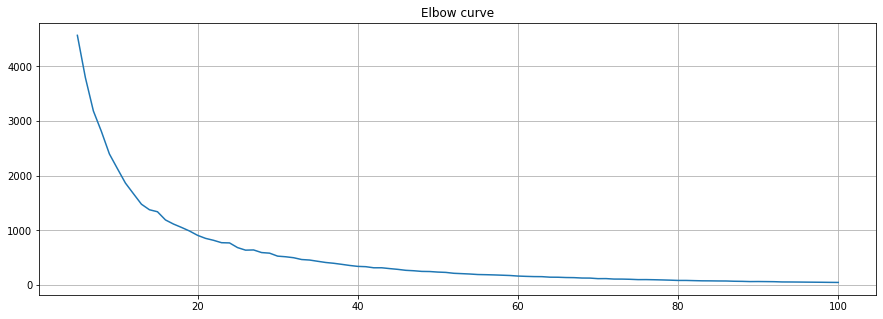

In [145]:
print("##"*30)
print("K-Means Clustering")
print("##"*30)
# 시도해 볼 cluster 수
cluster_number = range(5,101)
distortions = []
processed_data = tsnedata.copy()
scaler = preprocessing.MinMaxScaler()
scaler.fit_transform(processed_data[['x', 'y']])

# 모델 학습
for k in cluster_number:
    Clustering_Method = KMeans(n_clusters=k, random_state = 0)
    #X = model.docvecs.vectors_docs 
    Clustering_Method.fit(processed_data)
    distortions.append(Clustering_Method.inertia_)
    
# Elbow Curve 시각화
fig = plt.figure(figsize=(15, 5))
plt.plot(cluster_number, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

### silhouette


In [146]:
k_range = range(5, 101)

best_n = -1
best_silhouette_score = -1
X = model.docvecs.vectors_docs 
    
for k in k_range :
  Clustering_Method = KMeans(n_clusters=k, random_state = 0)
  Clustering_Method.fit(processed_data)
  clusters = Clustering_Method.predict(processed_data)

  score = silhouette_score(processed_data, clusters)
  
  print('k: ',k, "score: ",score)

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score
print('best n : ', best_n, "best_score : ", best_silhouette_score)

k:  5 score:  0.36932653
k:  6 score:  0.36551702
k:  7 score:  0.36438072
k:  8 score:  0.37224853
k:  9 score:  0.3710182
k:  10 score:  0.36451367
k:  11 score:  0.3827233
k:  12 score:  0.39188173
k:  13 score:  0.4032098
k:  14 score:  0.39560923
k:  15 score:  0.37500212
k:  16 score:  0.39767012
k:  17 score:  0.38938722
k:  18 score:  0.3889984
k:  19 score:  0.38255
k:  20 score:  0.39807418
k:  21 score:  0.39854223
k:  22 score:  0.38371792
k:  23 score:  0.39275026
k:  24 score:  0.38994217
k:  25 score:  0.4058668
k:  26 score:  0.40794054
k:  27 score:  0.39081877
k:  28 score:  0.4100554
k:  29 score:  0.40568027
k:  30 score:  0.41656378
k:  31 score:  0.4071313
k:  32 score:  0.4186433
k:  33 score:  0.4277959
k:  34 score:  0.41303328
k:  35 score:  0.42276296
k:  36 score:  0.42536545
k:  37 score:  0.43224216
k:  38 score:  0.43380263
k:  39 score:  0.4406735
k:  40 score:  0.4392344
k:  41 score:  0.44475138
k:  42 score:  0.4496444
k:  43 score:  0.43692082
k:  44

### hierarchical clustering

In [42]:
linkages = ['single', 'average','complete']

k_range = range(5, 20)
k_silhouette_df = pd.DataFrame(k_range, columns = ['k'])
X = model.docvecs.vectors_docs
for connect in linkages:
  k_silhouette = []
  
  for k in k_range:
    clustering = AgglomerativeClustering(n_clusters = k, linkage = connect)
    clusters = clustering.fit_predict(X)
    score = silhouette_score(X, clusters)

    result = [score]
    k_silhouette.append(result)
  score_df = pd.DataFrame(k_silhouette, columns = [connect + '_score'])
  k_silhouette_df = pd.concat([k_silhouette_df, score_df], axis=1)
k_silhouette_df

k  single_score  average_score  complete_score
0    5      0.467236       0.482265        0.396999
1    6      0.415620       0.522251        0.358927
2    7      0.048082       0.518866        0.358670
3    8      0.086050       0.512525        0.352175
4    9      0.084074       0.498796        0.350292
5   10      0.086196       0.495569        0.332015
6   11      0.078025       0.422134        0.307837
7   12      0.061595       0.423188        0.305963
8   13      0.048129       0.440737        0.335484
9   14     -0.189238       0.443506        0.360982
10  15     -0.183860       0.430982        0.366279
11  16     -0.187854       0.428823        0.363884
12  17     -0.285288       0.427678        0.372012
13  18     -0.282642       0.423364        0.372532
14  19     -0.437306       0.397940        0.370926

### K_means 사용한 clustering 결과

In [148]:
from math import*
def euclidean_distance(x, y):
    return sqrt(sum(pow(a - b, 2) for a, b in zip(x, y)))

In [220]:
Clustering_Method = KMeans(n_clusters=14, random_state=0)
X = model.docvecs.vectors_docs # document vector 전체를 가져옴. 
Clustering_Method.fit(processed_data)# fitting 

#Clustering_Method.cluster_centers_
cluster_dict = {i:[] for i in range(0, 14)}
for text, label in zip(range(len(doc_vec)), Clustering_Method.labels_):
    a = []
    a.append(doc_vec['convrs'].loc[text])
    a.append([doc_vec['tsne_x'].loc[text],doc_vec['tsne_y'].loc[text]])
    cluster_dict[label].append(a)

item_all = pd.DataFrame(columns = ['cluster','convrs','x','y','distance'])

for label, lst in cluster_dict.items():
    item = pd.DataFrame(columns = ['cluster','convrs','x','y','distance'])
    print(f"Cluster {label}")
    for x , y in zip(lst, Clustering_Method.cluster_centers_):
        print(x)
        distance = euclidean_distance(x[1],y)
        new_df = pd.DataFrame({'cluster':label,
                              'convrs':x[0],
                               'x': x[1][0],
                               'y': x[1][1],
                               'distance': distance}, index=[0])
        item = pd.concat([item,new_df], ignore_index = True)
    item = item.sort_values('distance')
    item_all = pd.concat([item_all,item], ignore_index = True)
    
    print("--"*30)
print("##"*20)

Cluster 0
['같이 일선발이 나와서 이렇게 게임을 했는데 일회 하고 이회 시작할 때 비가 엄청 오는거야그래서 평소에 기아 타이거즈가 쫌 잘하면 이 팬으로써 왠지 그날 하루가 즐겁더라고진짜 하루 일과가 재밌고 마무리가 잘 되는데 이게 게임을 졌다 하면 쫌우울하더라고제가 봤을 때 보니까 이 경기에 질이 쫌 많이 떨어지는 것 같다는 생각이 들더라고요 이게 처음부터 이렇게 에러가 많이 나오고 점수가 많이 나와서 경기의 질이 쫌 떨어지더라고아무튼 그런 걸보면은 정말 게임의 질이 쫌 많이 떨어지지 않느냐 그런 생각이 들더라고요 심판들이 이제 물론 비디오 판독도 하고 여러 가지 하고 있지만 거기에서 쫌 뭐랄까 저는 좀 그런 행태를 보면서 참 좀 아쉽다라는 그런 부분이 쫌 없지 않아 있더라고요 그런 시절도 있었는데 지금은 그때처럼 그러지 않고 관중의 성향이 그냥 경기를 즐기는 같아 그러니까 앞으로는 이제 기아도 부분을 잘 인지해서 발전해 나가야 될 것 같아 근데 제가 최근에 야구장을 갔던 게 그 한화의 이범호 선수 은퇴 경기를 갔었거든요그런 걸 보면서 한선수가 이 정말 치열한 경쟁 속에서 멋지게 은퇴하는구나라고 느꼈어 그러니까 보는 팬으로써는 좀 상황이 나아지지 않았나그런 생각이 들어서 참 다행이야저는 아까 말씀하신 것처럼 우승할 때는 핵 터라든가 그 외국인 투수들이 잘 해왔잖아요그래서 나머지 두명 이제 자자 버나디나까지 있지만 그것도 국내 선수들이 잘 받춰 줘야지어쨌든 혼자 고군분투하고 있는데 그 위에 선발투수들이 좀 받쳐 줄 수 있으면 참 좋겠어아무튼 그렇게 딱 떨어져 가지고 홈런볼 한번 주워 봤고 그다음에는 또 한번은 유한준 선수 있지 그 볼을 줍는 게 또 티비 화면에 나오면 안 되니까 이제 그 정도로 하는 거지그런 상황이 이제 많이 있었는데 보면 그 야구팬들의 그 열정이 참 강한 것 같더라고요 진짜 야구를 좋아하는 팬들은 그 공값이 얼마 되지는 않겠지만 그 기념으로 하는 거죠진짜 상상만 해도 그 어두캄캄한 밤하늘에 하얀 공이 허공을 쫙 가르면서 이렇게 오잖아요

In [225]:
item_all

cluster                                             convrs          x  \
0         0  같이 일선발이 나와서 이렇게 게임을 했는데 일회 하고 이회 시작할 때 비가 엄청 오...  12.490463   
1         0  그래서 평소에 기아 타이거즈가 좀 잘했으면 이 팬으로서 왠지 그날 하루가 즐겁더라고...  10.364326   
2         0  프로야구가 후반기가 이제 시작했고 어제부터 시작을 했는데 어제 양현종이가 나왔더라고...  14.677295   
3         0  불안할 때도 많더라고 멘탈이 좀 약한가 봐 나도 봤어정말 멋있지근데 그렇게 샷을 사...  13.199846   
4         0  그 양현종 기아 타이거즈 에이스가 나와서 두산하고 했는데 일회에 우천 취소가 됐어 ...  13.901575   
..      ...                                                ...        ...   
177      13  그것도 춤이지만 일종의 운동인데 이제는 대중화가 되어서 다 할 수 있어 댄스 스포츠...   1.865920   
178      13  수영 갔다 왔는데 오늘은 조금 피곤하긴 했지만 최선을 다해 열심히 했는데 속도가 조...  -1.722658   
179      13  수영을 갔다 왔는데 오늘은 조금 피곤하긴 했지만 최선을 다해 열심히 했는데 무엇으로...  -1.465578   
180      13  그래서 수영하는 게 훨씬 어렵지 거북이 등인가 그것을 한 육개월 찼나 봐결국에는 수...  -0.865939   
181      13  운전하는 게 더 어려워 수영하는 게 더 어려워 이렇게 물어보는 거야결국에는 수영은 ...  -1.186689   

             y   distance  
0    -3.619351   1.099819  
1    -2.609031   5.557726  
2    -4.900813   8.834324  
3     0.639269  12.902876  
4    -4.380680  13.934010  
..         ...        ...  
177 -11.166075  14.058891  
178 -13.726096  14.128987  
179 -12.393676  15.325132  
180 -11.438317  18.204737  
181 -11.904593  18.787677  

[165 rows x 5 columns]

In [249]:
item_all.drop(item_all[item_all['distance']>20].index, inplace = True)

In [227]:
item_all.to_csv("item_all.csv")

In [224]:
item_all.loc[item_all['cluster']==9]

cluster                                             convrs          x  \
122       9  맞아 김효주도 사실 우승권에 몇 번 갔었는데 이등 삼등으로 밀려나잖아박성현은 흔들려...  10.651670   
123       9  그래써 조금은 내려놓고 했으면 좋겠다는 거고 아까 또 야구 얘기했잖아 메이저리그에써...   8.110484   
124       9  그런 생각에서 한 얘기고 나는 그 전에도 그렇지만 일단은 즐기는 거야내가 스포츠를 ...   9.578847   
125       9  볼을 던지는 거에 있어서는 스피드는 썩 빠르지 않은데 기술이 엄청 좋잖아요그런 부분...   8.157745   
126       9  그게 다 어떻게 보면 인간승리라고 나는 그렇게 생각을 하고 있거든골프도 골프지만 작...   9.751396   
127       9  그렇지만 나는 항시 스포츠를 보면 재미있고 스포츠 나름의 쾌락이 있잖아자네는 스포츠...   6.713362   
128       9  예전에 이용규 전성기였을 때 보면 아주 성실하면서 근성 있게 했잖아그리고 한화에서 ...   4.737500   
129       9  나도 너무 안타까웠어그것 때문에 우승권에서 밀려나 버렸잖아그러니까 샷 하나하나를 정...  10.407436   
130       9  요즘 자네가 스포츠 중에 관심 있는 게 야구라고 했는데 요즘에 게임 보는 거 있어 ...   4.201800   
131       9  그래서 나는 올해 십위로 보고 있어 내 말이 맞을지 틀릴지 봐봐근데 류현진이 점수를...   5.477658   
132       9  그런데 이번 시리즈는 꽁찌야그나마 고교생 출신 정은원이 그 선수가 잘할 텐데 이년차...   7.770023   
133       9  메이저리그에서 류현진 컷쇼하고 힐하고 던지고 하는 걸 감명 깊게 보거든자기 관리를 ...   8.110033   
134       9  류현진이나 이런 좋아하는 선수가 나오면 나는 꼭 야구를 보고 그러거든보통 십 이승을...   8.142488   
135       9  근데 우리 한화 애들이 정은원 제외하고 근성이 없어졌다꼬 생각 해 예전에 이용규 전...   5.699296   

            y   distance  
122  0.436036   3.106499  
123  1.775394   5.485848  
124 -1.065524   6.221099  
125  1.851849   7.536940  
126  4.095491   7.564685  
127 -0.657232   8.739228  
128  1.449041   9.636032  
129  0.244571  10.104809  
130 -1.696811  11.396848  
131  1.524258  11.831889  
132 -2.067763  11.899975  
133 -0.105983  13.720879  
134  0.387477  18.288454  
135  1.738834  18.406479

## training, validation set 나누기
나누어진 군집을 확인 후, 요약문 만들기


짝수번은 training, 홀수번은 validation set으로 나누기

In [246]:
summ_sen = ["야구에 관한 이야기를 하고 있다.",
            "운동을 권장하고 있다.",
            "",
            "축구에 관한 이야기를 하고 있다.",
            "헬스, 요가에 대해 이야기 하고 있다,",
            "골프에 흥미를 보이고 있다.",
            "",
            "등산에 대해 흥미를 보이고 있다.",
            "몸에 무리가 가지 않는 운동을 하고 싶어한다.",
            "좋아하는 야구 선수에 대해 이야기하고 있다.",
            "운동에 재미와 흥미를 보이고 있다.",
            "골프를 잘 칠 수 있는 자세에 대해 이야기하고 있다.",
            "탁구에 대해 이야기하고 있다.",
            "수영에 대해 이야기하고 있다."]

for i in range(14):
  if i == 2 or i==7:
    item_all.drop(item_all[item_all['cluster']==i].index, inplace = True)
  else:
    item_all.loc[item_all['cluster'] == i, 'cluster'] = summ_sen[i]

item_all

cluster                                             convrs  \
0    야구에 관한 이야기를 하고 있다.  같이 일선발이 나와서 이렇게 게임을 했는데 일회 하고 이회 시작할 때 비가 엄청 오...   
1    야구에 관한 이야기를 하고 있다.  그래서 평소에 기아 타이거즈가 좀 잘했으면 이 팬으로서 왠지 그날 하루가 즐겁더라고...   
2    야구에 관한 이야기를 하고 있다.  프로야구가 후반기가 이제 시작했고 어제부터 시작을 했는데 어제 양현종이가 나왔더라고...   
3    야구에 관한 이야기를 하고 있다.  불안할 때도 많더라고 멘탈이 좀 약한가 봐 나도 봤어정말 멋있지근데 그렇게 샷을 사...   
4    야구에 관한 이야기를 하고 있다.  그 양현종 기아 타이거즈 에이스가 나와서 두산하고 했는데 일회에 우천 취소가 됐어 ...   
..                  ...                                                ...   
177    수영에 대해 이야기하고 있다.  그것도 춤이지만 일종의 운동인데 이제는 대중화가 되어서 다 할 수 있어 댄스 스포츠...   
178    수영에 대해 이야기하고 있다.  수영 갔다 왔는데 오늘은 조금 피곤하긴 했지만 최선을 다해 열심히 했는데 속도가 조...   
179    수영에 대해 이야기하고 있다.  수영을 갔다 왔는데 오늘은 조금 피곤하긴 했지만 최선을 다해 열심히 했는데 무엇으로...   
180    수영에 대해 이야기하고 있다.  그래서 수영하는 게 훨씬 어렵지 거북이 등인가 그것을 한 육개월 찼나 봐결국에는 수...   
181    수영에 대해 이야기하고 있다.  운전하는 게 더 어려워 수영하는 게 더 어려워 이렇게 물어보는 거야결국에는 수영은 ...   

             x          y   distance  
0    12.490463  -3.619351   1.099819  
1    10.364326  -2.609031   5.557726  
2    14.677295  -4.900813   8.834324  
3    13.199846   0.639269  12.902876  
4    13.901575  -4.380680  13.934010  
..         ...        ...        ...  
177   1.865920 -11.166075  14.058891  
178  -1.722658 -13.726096  14.128987  
179  -1.465578 -12.393676  15.325132  
180  -0.865939 -11.438317  18.204737  
181  -1.186689 -11.904593  18.787677  

[138 rows x 5 columns]

In [247]:
df_training = item_all.iloc[::2,:]
df_training

cluster                                             convrs  \
0    야구에 관한 이야기를 하고 있다.  같이 일선발이 나와서 이렇게 게임을 했는데 일회 하고 이회 시작할 때 비가 엄청 오...   
2    야구에 관한 이야기를 하고 있다.  프로야구가 후반기가 이제 시작했고 어제부터 시작을 했는데 어제 양현종이가 나왔더라고...   
4    야구에 관한 이야기를 하고 있다.  그 양현종 기아 타이거즈 에이스가 나와서 두산하고 했는데 일회에 우천 취소가 됐어 ...   
6    야구에 관한 이야기를 하고 있다.  그럴 때면 또 좀 우울하고 그리고 또 내일 또 잘하겠지 하고 그런 생각을 갖기도 해...   
11         운동을 권장하고 있다.  그런 애로사항이 있어 누가 선뜻 같이 해보자는 사람도 없는 상태이고 그 사람들이 자...   
..                  ...                                                ...   
172    수영에 대해 이야기하고 있다.  그래서 수영이 다리에도 무리가 덜 가니까 수영 쪽으로 생각을 하고 있는데 골프를 치...   
174    수영에 대해 이야기하고 있다.  내가 해보니까 진짜 좋은 것 같아 개운하기도 하고 건강해지는 것 같아 요즘 내가 건...   
176    수영에 대해 이야기하고 있다.  무엇으로 했냐하면 처음에는 스타트 하는 것 있잖아 물 속에 깊이 들어가는 것 매칠 ...   
178    수영에 대해 이야기하고 있다.  수영 갔다 왔는데 오늘은 조금 피곤하긴 했지만 최선을 다해 열심히 했는데 속도가 조...   
180    수영에 대해 이야기하고 있다.  그래서 수영하는 게 훨씬 어렵지 거북이 등인가 그것을 한 육개월 찼나 봐결국에는 수...   

             x          y   distance  
0    12.490463  -3.619351   1.099819  
2    14.677295  -4.900813   8.834324  
4    13.901575  -4.380680  13.934010  
6    11.732469  -3.202197  16.021466  
11   -3.349685  -4.365010   2.405182  
..         ...        ...        ...  
172   0.765554 -10.584315   9.687332  
174  -5.243612 -10.894806  12.334912  
176  -1.627153 -12.381935  13.848597  
178  -1.722658 -13.726096  14.128987  
180  -0.865939 -11.438317  18.204737  

[69 rows x 5 columns]

In [248]:
df_validation = item_all.iloc[1::2,:]
df_validation

cluster                                             convrs  \
1    야구에 관한 이야기를 하고 있다.  그래서 평소에 기아 타이거즈가 좀 잘했으면 이 팬으로서 왠지 그날 하루가 즐겁더라고...   
3    야구에 관한 이야기를 하고 있다.  불안할 때도 많더라고 멘탈이 좀 약한가 봐 나도 봤어정말 멋있지근데 그렇게 샷을 사...   
5    야구에 관한 이야기를 하고 있다.  근데 그렇게 멋있는 샷을 사라운드에서도 했어도 한번 무너지면 그래 맞아 김효주도 사...   
7    야구에 관한 이야기를 하고 있다.  그 경기 하다가 우천 중단으로 결국은 그날 게임이 노게임이 선언됐어요어제 보니까 굉...   
12         운동을 권장하고 있다.  요즘 선생님 이렇게 보시면 사람들이 참 건강에 대해서 관심이 많잖아요제가 아침에 우...   
..                  ...                                                ...   
173    수영에 대해 이야기하고 있다.  속도가 조금 늘은 긋 같아 예전보다 끝나고 나서 따로 연습도 했지무엇으로 했냐 하면...   
175    수영에 대해 이야기하고 있다.  시작할 때 기분은 어땠니 혹시 하기 싫었는데 우리 때문에 억지로 한 건 아닌지 커서...   
177    수영에 대해 이야기하고 있다.  그것도 춤이지만 일종의 운동인데 이제는 대중화가 되어서 다 할 수 있어 댄스 스포츠...   
179    수영에 대해 이야기하고 있다.  수영을 갔다 왔는데 오늘은 조금 피곤하긴 했지만 최선을 다해 열심히 했는데 무엇으로...   
181    수영에 대해 이야기하고 있다.  운전하는 게 더 어려워 수영하는 게 더 어려워 이렇게 물어보는 거야결국에는 수영은 ...   

             x          y   distance  
1    10.364326  -2.609031   5.557726  
3    13.199846   0.639269  12.902876  
5    13.176327   0.655462  15.066050  
7    13.984743  -4.440639  19.435703  
12   -5.581920  -3.355764   5.807683  
..         ...        ...        ...  
173  -1.573866 -12.906236  10.317737  
175   4.776040 -12.602444  13.212035  
177   1.865920 -11.166075  14.058891  
179  -1.465578 -12.393676  15.325132  
181  -1.186689 -11.904593  18.787677  

[69 rows x 5 columns]